### [문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std.값 찾기

In [2]:
import os
import torch
from torchvision import datasets, transforms

data_path = os.path.join("_00_data", "j_fashion_mnist")

# Fashion MNIST 데이터 로드 (train 데이터셋만 사용)
fashion_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())

# 모든 이미지를 하나의 텐서로 스택
imgs = torch.stack([img_t for img_t, _ in fashion_mnist_train], dim=3)

# 전체 픽셀 값으로 평균과 표준편차 계산
mean = imgs.view(1, -1).mean(dim=-1)
std = imgs.view(1, -1).std(dim=-1)

print(f"Mean: {mean.item():.9f}, Std: {std.item():.9f}")


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 18.7MB/s]


Mean: 0.286040604, Std: 0.353024244


In [3]:
!git clone https://github.com/Jwswill/deep-learning/
!pip install torchinfo
%cd /content/deep-learning

import sys
sys.path.append('/content/deep-learning/_03_homeworks/homework_3')
sys.path.append('/content/deep-learning/_01_code/_99_common_utils')

from a_fashion_mnist_data import get_fashion_mnist_data


Cloning into 'deep-learning'...
remote: Enumerating objects: 2524, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 2524 (delta 0), reused 0 (delta 0), pack-reused 2519 (from 1)
Receiving objects: 100% (2524/2524), 109.92 MiB | 31.36 MiB/s, done.
Resolving deltas: 100% (1727/1727), done.
Updating files: 100% (282/282), done.
/content/deep-learning
/content/deep-learning


### [문제2] Fashion MNIST 데이터에 대하여 CNN 학습시키기

In [4]:
import os
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader
import wandb
from torchinfo import summary  # 모델 구조 출력용
from a_fashion_mnist_data import get_fashion_mnist_data  # 데이터 로드 함수

# EarlyStopping 클래스 정의
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, delta=0.0001, checkpoint_path="best_model.pth"):
        """
        초기화
        :param patience: 검증 손실이 개선되지 않을 때 기다리는 에폭 수
        :param delta: 개선 최소값 (작을수록 민감)
        :param checkpoint_path: 모델 체크포인트 저장 경로
        """
        self.patience = patience
        self.counter = 0
        self.delta = delta
        self.best_loss = None
        self.early_stop = False
        self.checkpoint_path = checkpoint_path

    def __call__(self, val_loss, model):
        """
        검증 손실을 평가하고 필요 시 체크포인트 저장.
        :param val_loss: 현재 에폭의 검증 손실
        :param model: 현재 모델
        """
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.checkpoint_path)  # 모델 저장
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# GPU/CPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Wandb 초기화
wandb.init(project="fashion-mnist", config={
    "batch_size": 128,  # 배치 크기
    "learning_rate": 0.001,  # 학습률
    "epochs": 30,  # 최대 학습 에폭
    "weight_decay": 1e-4  # 가중치 감소율
})
config = wandb.config

# 데이터 증강 및 데이터 로드
train_transforms = transforms.Compose([
    transforms.RandomCrop(28, padding=4),  # 랜덤 크롭
    transforms.RandomHorizontalFlip(),  # 랜덤 가로 뒤집기
    transforms.ToTensor(),
    transforms.Normalize(mean=0.28604060411453247, std=0.3530242443084717)  # 정규화
])
val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.28604060411453247, std=0.3530242443084717)  # 정규화
])

# 학습 및 검증 데이터 로드
train_loader, val_loader, _ = get_fashion_mnist_data()
train_loader.dataset.dataset.transform = train_transforms  # 학습 데이터에 변환 적용
val_loader.dataset.dataset.transform = val_transforms  # 검증 데이터에 변환 적용

# CNN 모델 정의
class ModernCNN(nn.Module):
    """Fashion MNIST 분류를 위한 CNN 모델."""
    def __init__(self):
        super(ModernCNN, self).__init__()
        self.network = nn.Sequential(
            # 첫 번째 Convolutional Block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),  # 배치 정규화
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),  # 다운샘플링
            nn.Dropout(0.4),  # 드롭아웃

            # 두 번째 Convolutional Block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.4),

            # Fully Connected Layer
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 512),  # 완전 연결 계층
            nn.ReLU(),
            nn.BatchNorm1d(512),  # 배치 정규화
            nn.Dropout(0.5),
            nn.Linear(512, 10)  # 출력 계층 (10 클래스)
        )

    def forward(self, x):
        return self.network(x)

# 모델 생성 및 장치로 이동
model = ModernCNN().to(device)

# 모델 구조 출력
print("Model Summary:")
print(summary(model, input_size=(config.batch_size, 1, 28, 28), device=device))

# 손실 함수 및 최적화 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # 학습률 스케줄러

# EarlyStopping 초기화
early_stopping = EarlyStopping(patience=10, checkpoint_path="modern_cnn_best.pth")

# 학습 루프 함수
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    모델을 한 에폭 동안 학습하는 함수.
    :param model: 학습할 모델
    :param train_loader: 학습 데이터 로더
    :param criterion: 손실 함수
    :param optimizer: 최적화 알고리즘
    :param device: 장치 (GPU 또는 CPU)
    :return: 학습 손실, 학습 정확도
    """
    model.train()
    train_loss, train_acc = 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += (outputs.argmax(1) == labels).float().mean().item()
    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    return train_loss, train_acc

# 검증 루프 함수
def validate(model, val_loader, criterion, device):
    """
    모델을 검증 데이터로 평가하는 함수.
    :param model: 평가할 모델
    :param val_loader: 검증 데이터 로더
    :param criterion: 손실 함수
    :param device: 장치 (GPU 또는 CPU)
    :return: 검증 손실, 검증 정확도
    """
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_acc += (outputs.argmax(1) == labels).float().mean().item()
    val_loss /= len(val_loader)
    val_acc /= len(val_loader)
    return val_loss, val_acc

# 메인 학습 루프
for epoch in range(config.epochs):
    # Training
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validation
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # Learning Rate 업데이트
    scheduler.step()

    # Wandb 기록
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss, "train_acc": train_acc,
        "val_loss": val_loss, "val_acc": val_acc
    })

    # 학습 결과 출력
    print(f"Epoch {epoch + 1}/{config.epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early Stopping 체크
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

print(f"Training stopped. Best Validation Loss: {early_stopping.best_loss:.4f}")

# 최적 모델 로드
model.load_state_dict(torch.load(early_stopping.checkpoint_path))  # 체크포인트에서 모델 복원


Using device: cuda


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jwswill0720 (jwswill0720-korea-university-of-technology-and-education) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Num Train Samples:  55000
Num Validation Samples:  5000
Sample Data Shape:  torch.Size([1, 28, 28])
Sample Data Target:  4
Number of Data Loading Workers: 12
Model Summary:
Layer (type:depth-idx)                   Output Shape              Param #
ModernCNN                                [128, 10]                 --
├─Sequential: 1-1                        [128, 10]                 --
│    └─Conv2d: 2-1                       [128, 32, 28, 28]         320
│    └─ReLU: 2-2                         [128, 32, 28, 28]         --
│    └─BatchNorm2d: 2-3                  [128, 32, 28, 28]         64
│    └─Conv2d: 2-4                       [128, 64, 28, 28]         18,496
│    └─ReLU: 2-5                         [128, 64, 28, 28]         --
│    └─BatchNorm2d: 2-6                  [128, 64, 28, 28]         128
│    └─MaxPool2d: 2-7                    [128, 64, 14, 14]         --
│    └─Dropout: 2-8                      [128, 64, 14, 14]         --
│    └─Conv2d: 2-9                       [128,

<All keys matched successfully>

### 최적의 하이퍼파라미터
* Learning Rate: 0.001
    * 학습 속도를 최적화하여 과대적합과 과소적합 사이의 균형을 맞춤.
* Batch Size: 128
    * GPU 메모리 효율성을 고려하여 최적의 배치 크기를 설정.
* Early Stop Patience: 10
    * 검증 손실이 개선되지 않을 경우 학습을 조기 종료하여 시간 절약.
* Weight Decay Value: 1e-4
    * 과적합 방지를 위한 정규화 기법.
* Normalization Type:
    * 데이터 평균: 0.2860
    * 데이터 표준편차: 0.3530
    * 데이터 정규화를 통해 학습 안정성 개선.
* Dropout Rate:
    * Convolutional Layer: 0.4
    * Fully Connected Layer: 0.5
    * 드롭아웃 비율 조정을 통해 과적합 방지.

### 모델 설계
* Modern CNN Architecture
* 구조
    1.Convolutional Layers
        * 입력 데이터: 28x28 크기의 단일 채널 이미지.
        * 두 개의 컨볼루션 블록:
            * 각 블록에 Conv2D, ReLU, BatchNorm, MaxPool 적용.
            * 드롭아웃 비율: 0.4
    2. Fully Connected Layers
        * Flatten 후 Dense Layer로 연결.
        * 중간 뉴런: 512
        * 드롭아웃 비율: 0.5
        * 최종 출력: 10 클래스 (Softmax 활성화 함수 사용).
    3. Batch Normalization
        * 모든 Convolutional Block과 Fully Connected Layer에 적용.

### 최적화 기법
* 손실 함수
    * Cross Entropy Loss
        * 다중 클래스 분류 문제를 위한 손실 함수.
* 최적화 알고리즘
    * Adam Optimizer
    * 학습률: 0.001
    * 가중치 감소율: 1e-4
* Learning Rate Scheduler
    * StepLR
        * 10 에폭마다 학습률을 0.5배로 감소.

### [문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

In [5]:
# Test 데이터 평가 함수
def evaluate_data(model, data_loader, criterion, device):
    """
    데이터셋에서 모델 성능을 평가하는 함수.
    :param model: 평가할 모델
    :param data_loader: 평가 데이터 로더
    :param criterion: 손실 함수
    :param device: 사용 장치 (GPU 또는 CPU)
    :return: 평균 손실, 정확도
    """
    model.eval()  # 평가 모드 전환
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # 그래디언트 계산 비활성화
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # 데이터 장치로 이동

            # Forward pass
            outputs = model(inputs)  # 예측값 계산
            loss = criterion(outputs, labels)  # 손실 계산

            # 손실 누적
            total_loss += loss.item()

            # 정확도 계산
            correct_predictions += (outputs.argmax(1) == labels).sum().item()  # 올바른 예측 수 누적
            total_samples += labels.size(0)  # 전체 샘플 수 누적

    # 평균 손실 및 정확도 계산
    avg_loss = total_loss / len(data_loader)  # 평균 손실
    accuracy = correct_predictions / total_samples  # 정확도
    return avg_loss, accuracy


# Test 데이터 로드 및 평가
from a_fashion_mnist_data import get_fashion_mnist_test_data

# Test 데이터 전처리 설정
test_transforms = transforms.Compose([
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=0.28604060411453247, std=0.3530242443084717)  # 정규화
])

# Test 데이터 로드
_, test_loader, _ = get_fashion_mnist_test_data()

# Test 데이터셋에 전처리(transform) 적용
test_loader.dataset.transform = test_transforms  # Normalize 적용

# 최적 모델 로드
print("Loading the best model for evaluation...")
model.load_state_dict(torch.load(early_stopping.checkpoint_path))  # 저장된 체크포인트 로드

# Validation 데이터 재평가
val_loss, val_acc = evaluate_data(model, val_loader, criterion, device)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc * 100:.2f}%")

# Test 데이터셋 평가
test_loss, test_acc = evaluate_data(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")


Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
Loading the best model for evaluation...
Validation Loss: 0.1376, Validation Accuracy: 94.56%
Test Loss: 0.1787, Test Accuracy: 93.87%


### [문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기

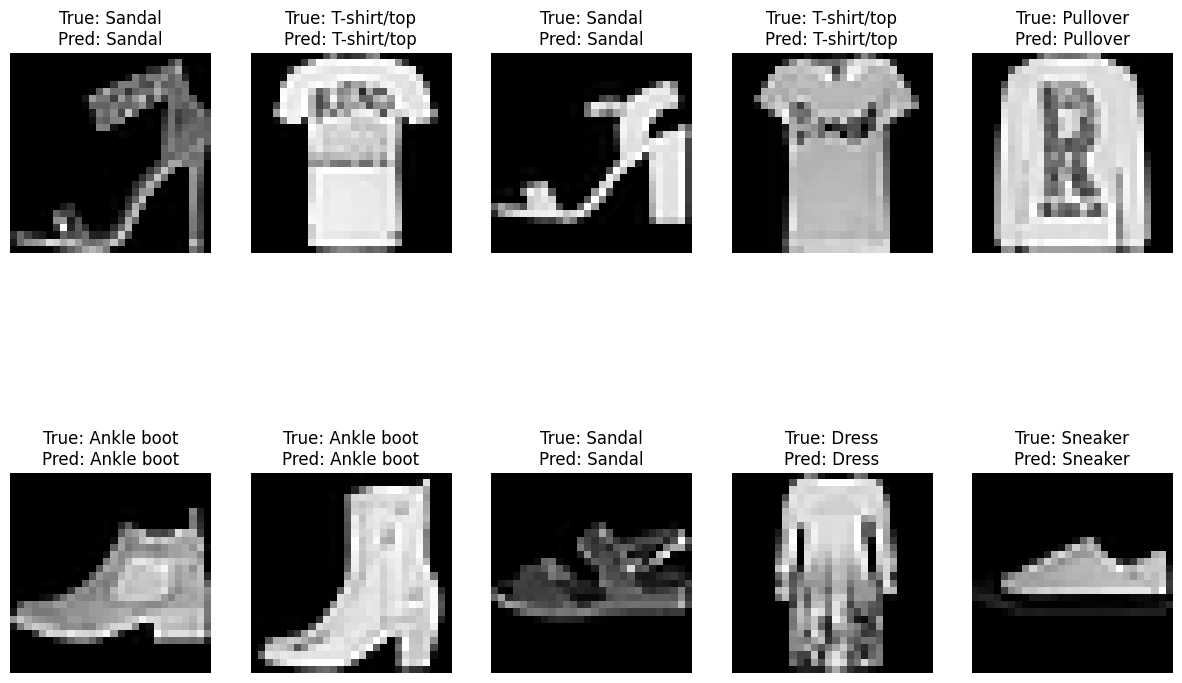

Total Correct Predictions: 10/10
Accuracy on 10 samples: 100.00%


In [6]:
import random
import matplotlib.pyplot as plt
import torch

# 샘플 10개를 선택하여 예측 및 시각화
def evaluate_sample_predictions(model, test_loader, device, class_names):
    """
    테스트 데이터에서 랜덤하게 10개 샘플을 선택하여 예측 결과를 시각화하고 평가하는 함수.

    :param model: 평가할 모델
    :param test_loader: 테스트 데이터 로더
    :param device: 모델이 실행될 장치 (GPU 또는 CPU)
    :param class_names: FashionMNIST 클래스 이름 리스트
    """
    model.eval()  # 평가 모드 전환 (Dropout 비활성화)

    # 10개의 랜덤 샘플 인덱스 선택
    random_indices = random.sample(range(len(test_loader.dataset)), 10)
    samples = [test_loader.dataset[i] for i in random_indices]  # 선택된 인덱스에 해당하는 샘플 추출

    # 이미지와 레이블 준비
    images, labels = zip(*samples)  # 이미지와 레이블을 분리
    images = torch.stack(images).to(device)  # 이미지 텐서를 하나로 결합하고 장치로 이동
    labels = torch.tensor(labels).to(device)  # 레이블을 텐서로 변환하고 장치로 이동

    # 모델을 사용한 예측 수행
    with torch.no_grad():  # 그래디언트 계산 비활성화
        outputs = model(images)  # 모델의 예측값
        predictions = outputs.argmax(1)  # 가장 높은 점수를 받은 클래스 예측

    # 시각화 및 결과 출력
    plt.figure(figsize=(15, 10))  # 시각화 크기 설정
    for i in range(10):  # 10개의 샘플에 대해 반복
        plt.subplot(2, 5, i + 1)  # 2행 5열로 구성된 서브플롯 생성
        plt.imshow(images[i].cpu().squeeze(), cmap="gray")  # 이미지를 그레이스케일로 표시
        plt.title(
            f"True: {class_names[labels[i].item()]}\nPred: {class_names[predictions[i].item()]}"
        )  # 실제 클래스와 예측 클래스 출력
        plt.axis("off")  # 축 숨기기
    plt.show()  # 모든 시각화 출력

    # 레이블과 예측 결과 비교
    correct = (predictions == labels).sum().item()  # 올바른 예측 개수 계산
    print(f"Total Correct Predictions: {correct}/10")  # 정확히 예측한 샘플 개수 출력
    print(f"Accuracy on 10 samples: {correct / 10 * 100:.2f}%")  # 샘플에 대한 정확도 출력


# 클래스 이름 정의 (FashionMNIST 클래스)
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# 최적 모델 로드
model.load_state_dict(torch.load(early_stopping.checkpoint_path))  # 저장된 최적의 모델 체크포인트 로드

# 10개의 샘플로 예측 및 평가
evaluate_sample_predictions(model, test_loader, device, class_names)  # 테스트 데이터로 예측 수행


1. 모델의 일반화 능력 부족
학습 데이터에서 "Ankle boot"와 "Sneaker" 클래스를 착각했을 가능성.
비슷한 패턴(예: 신발 모양, 색상)이 두 클래스에 걸쳐 나타나 모델이 구별하지 못한거 같음
2. 데이터 증강 부족
학습 데이터에서 다양한 각도, 밝기, 패턴의 신발 이미지를 갖추지 못했을 가능성.

### 숙제후기
정확도를 높이는 여러 과정을 배우게 되었다.